In [2]:
#Importando bibliotecas necessárias
import pandas as pd
import basedosdados as bd
project_id = "acesso-bdd"
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from fastparquet import write, ParquetFile

Com base numa análise exploratória inicial, decidi que seria interessante analisar a correlação e a variação mensal do IPCA das categorias que compõe o índice.
Das tabelas do IPCA, utilizei a `mes_categoria_brasil` como você pode ver no código a seguir

In [3]:
#Download da base do IPCA
df_ipca = bd.read_table(dataset_id='br_ibge_ipca', 
                        table_id='mes_categoria_brasil',
                        billing_project_id = project_id)
#Salvando a base do IPCA em um arquivo parquet
#Assim, além de ser menor, não preciso fazer o download toda vez que for utilizar
write('df_ipca.parq', df_ipca)                      

Downloading: 100%|██████████| 10968/10968 [00:01<00:00, 5629.04rows/s]


In [4]:
#Importando a base do IPCA
pf = ParquetFile('df_ipca.parq')

#Criando um backup da base do IPCA
df_ipca_bak = pf.to_pandas()
df_ipca = df_ipca_bak.copy()

Aliado aos meus conhecimentos da faculdade, notei que a variável `id_categoria_bd` seguia um padrão, onde cada `.` separava um nível de categoria.
Optei então por separar cada categoria no `.` e criar novas colunas.
Assim eu teria mais liberdade para filtrar e analisar alguns dados.

A cada passo, eu gosto de analisar o df para enxergar se não estou cometendo nenhum erro em alguma transformação.

In [5]:
#Separando as categorias em colunas no caracter '.'
df_ipca[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = df_ipca['id_categoria_bd'].str.split('.', expand=True)
df_ipca

,ano,mes,id_categoria,id_categoria_bd,categoria,peso_mensal,variacao_mensal,variacao_anual,variacao_doze_meses,cat_1,cat_2,cat_3,cat_4
0,2020,1,1,1.0.00.000,Alimentação e bebidas,19.3483,0.39,0.39,NaN,1,0,00,000
1,2020,1,2,2.0.00.000,Habitação,15.5945,0.55,0.55,NaN,2,0,00,000
2,2020,1,3,3.0.00.000,Artigos de residência,3.7529,-0.07,-0.07,NaN,3,0,00,000
3,2020,1,4,4.0.00.000,Vestuário,4.5770,-0.48,-0.48,NaN,4,0,00,000
4,2020,1,5,5.0.00.000,Transportes,20.5979,0.32,0.32,NaN,5,0,00,000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10963,2021,8,None,0.0.00.000,Índice geral,100.0000,0.87,5.67,9.68,0,0,00,000
10964,2021,9,None,0.0.00.000,Índice geral,100.0000,1.16,6.90,10.25,0,0,00,000
10965,2021,10,None,0.0.00.000,Índice geral,100.0000,1.25,8.24,10.67,0,0,00,000
10966,2021,11,None,0.0.00.000,Índice geral,100.0000,0.95,9.26,10.74,0,0,00,000


Sabendo que quando `id_categoria_bd == X.0.00.000` representava a categoria mais geral, consegui avaliar o nome das categorias e se todas apareciam nos 24 meses analisados fazendo o filtro:

In [6]:
df_ipca[df_ipca['cat_2'] == '0']['categoria'].value_counts()

Vestuário                    24
Habitação                    24
Comunicação                  24
Alimentação e bebidas        24
Artigos de residência        24
Transportes                  24
Saúde e cuidados pessoais    24
Índice geral                 24
Despesas pessoais            24
Educação                     24
Name: categoria, dtype: int64

Com isso, notei que para um gráfico de linha seria interessante transformar as colunas `ano` e `mes` numa única referência já no formato de data do Python

In [7]:
#Criação da variável 'anomes'
i = 0
df_ipca['anomes'] = 0
for l in df_ipca.iterrows():
    df_ipca['anomes'][i] = datetime.date(int(df_ipca['ano'][i]), int(df_ipca['mes'][i]), 1)
    i += 1

A partir disso, decidi criar um dicionário para substituir a variável `cat_1` e manter só os índices principais

In [9]:
#Dicionário para substituir a coluna cat_1
categoria_1 = {'0':'Índice geral',
               '1':'Alimentação',
               '2':'Habitação',
               '3':'Art. residência',
               '4':'Vestuário',
               '5':'Transportes',
               '6':'Saúde',
               '7':'Desp. pessoal',
               '8':'Educação',
               '9':'Comunicação'}

#Substituindo os valores das categorias por nomes e mantendo só os índices
df_ipca['cat_1'].replace(categoria_1, inplace=True)

Ok! Até aqui tudo dando certo!
Meu interesse era encontrar as maiores correlações com o índice e fazer um gráfico.
Pra isso, preciso filtrar a tabela para ter somente índices.

In [10]:
df_ipca_indices = df_ipca[df_ipca['cat_2'] == '0']
df_ipca_indices

,ano,mes,id_categoria,id_categoria_bd,categoria,peso_mensal,variacao_mensal,variacao_anual,variacao_doze_meses,cat_1,cat_2,cat_3,cat_4,anomes
0,2020,1,1,1.0.00.000,Alimentação e bebidas,19.3483,0.39,0.39,NaN,Alimentação,0,00,000,2020-01-01
1,2020,1,2,2.0.00.000,Habitação,15.5945,0.55,0.55,NaN,Habitação,0,00,000,2020-01-01
2,2020,1,3,3.0.00.000,Artigos de residência,3.7529,-0.07,-0.07,NaN,Art. residência,0,00,000,2020-01-01
3,2020,1,4,4.0.00.000,Vestuário,4.5770,-0.48,-0.48,NaN,Vestuário,0,00,000,2020-01-01
4,2020,1,5,5.0.00.000,Transportes,20.5979,0.32,0.32,NaN,Transportes,0,00,000,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10963,2021,8,None,0.0.00.000,Índice geral,100.0000,0.87,5.67,9.68,Índice geral,0,00,000,2021-08-01
10964,2021,9,None,0.0.00.000,Índice geral,100.0000,1.16,6.90,10.25,Índice geral,0,00,000,2021-09-01
10965,2021,10,None,0.0.00.000,Índice geral,100.0000,1.25,8.24,10.67,Índice geral,0,00,000,2021-10-01
10966,2021,11,None,0.0.00.000,Índice geral,100.0000,0.95,9.26,10.74,Índice geral,0,00,000,2021-11-01


Para encontrar a correlação entre a **variação mensal**, criei a base a seguir, "transformei" linhas em colunas com o unstack e criei a tabela de correlações

In [11]:
#Criando um df com a Variação Mensal
df_ipca_VM = pd.DataFrame(df_ipca_indices.groupby(['anomes', 'cat_1'])['variacao_mensal'].sum())
df_ipca_VM

variacao_mensal
anomes     cat_1                           
2020-01-01 Alimentação                 0.39
           Art. residência            -0.07
           Comunicação                 0.12
           Desp. pessoal               0.35
           Educação                    0.16
...                                     ...
2021-12-01 Habitação                   0.74
           Saúde                       0.75
           Transportes                 0.58
           Vestuário                   2.06
           Índice geral                0.73

[240 rows x 1 columns]

In [12]:
#Criando uma matriz de correlação
df_ipca_corr = df_ipca_VM.unstack().corr()
df_ipca_corr

variacao_mensal                              \
cat_1                               Alimentação Art. residência Comunicação   
                cat_1                                                         
variacao_mensal Alimentação            1.000000        0.033895    0.012750   
                Art. residência        0.033895        1.000000    0.438061   
                Comunicação            0.012750        0.438061    1.000000   
                Desp. pessoal          0.026067        0.514677    0.052109   
                Educação              -0.159788       -0.153153   -0.348697   
                Habitação              0.020932        0.396955    0.047714   
                Saúde                 -0.268104        0.168754    0.187507   
                Transportes           -0.130197        0.588031    0.075508   
                Vestuário              0.214219        0.436055   -0.141394   
                Índice geral           0.202577        0.672298    0.089282   

                                                                             \
cat_1                           Desp. pessoal  Educação Habitação     Saúde   
                cat_1                                                         
variacao_mensal Alimentação          0.026067 -0.159788  0.020932 -0.268104   
                Art. residência      0.514677 -0.153153  0.396955  0.168754   
                Comunicação          0.052109 -0.348697  0.047714  0.187507   
                Desp. pessoal        1.000000  0.162483  0.492350 -0.029915   
                Educação             0.162483  1.000000 -0.104694  0.153613   
                Habitação            0.492350 -0.104694  1.000000 -0.115183   
                Saúde               -0.029915  0.153613 -0.115183  1.000000   
                Transportes          0.507005 -0.063691  0.450455 -0.080737   
                Vestuário            0.584257  0.015371  0.363432  0.103586   
                Índice geral         0.682825  0.046364  0.697628 -0.001266   

                                                                    
cat_1                           Transportes Vestuário Índice geral  
                cat_1                                               
variacao_mensal Alimentação       -0.130197  0.214219     0.202577  
                Art. residência    0.588031  0.436055     0.672298  
                Comunicação        0.075508 -0.141394     0.089282  
                Desp. pessoal      0.507005  0.584257     0.682825  
                Educação          -0.063691  0.015371     0.046364  
                Habitação          0.450455  0.363432     0.697628  
                Saúde             -0.080737  0.103586    -0.001266  
                Transportes        1.000000  0.388133     0.845545  
                Vestuário          0.388133  1.000000     0.604912  
                Índice geral       0.845545  0.604912     1.000000

<AxesSubplot:xlabel='None-cat_1', ylabel='None-cat_1'>

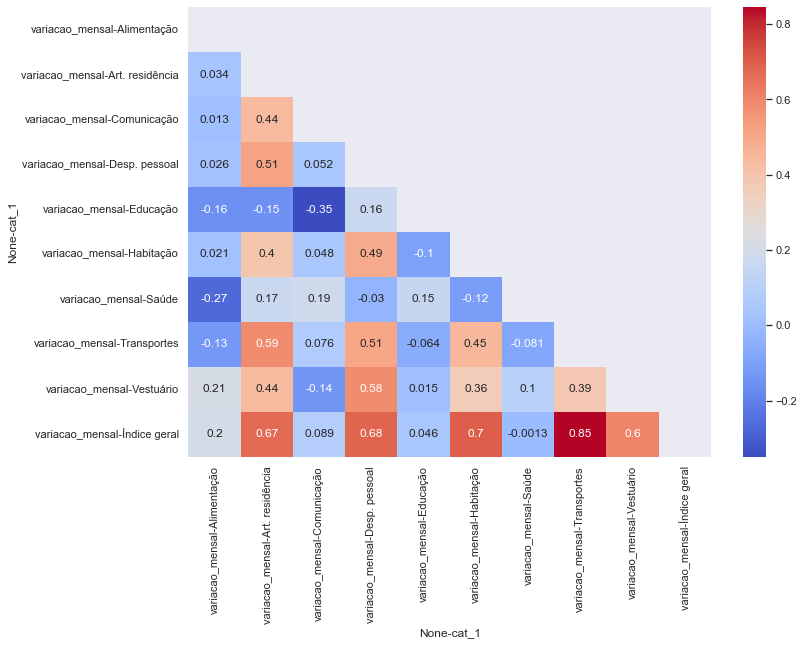

In [13]:
#Definindo o tamanho da figura
sns.set(rc={'figure.figsize':(11.7,8.27)})

#Visualizando a matriz de correlação
matrix = np.triu(df_ipca_corr)
sns.heatmap(df_ipca_corr,
            annot=True,
            mask=matrix,
            cmap='coolwarm')

A partir do gráfico a cima, descobri as categorias com as maiores correlações com o Índice Geral.
Porém, esse ainda não era meu objetivo final

```
Índice Geral    | 1
----------------------
Transportes     | 0.85
Habitação       | 0.7
Desp. pessoal   | 0.68
Art. residência | 0.67
```

In [14]:
#Selecionando as principais variáveis
df_ipca_indices_filtrado = df_ipca_indices[df_ipca_indices['cat_1'].isin(['Índice geral', 
                                                                          'Transportes', 
                                                                          'Habitação', 
                                                                          'Alimentação',
                                                                          'Art. residência',
                                                                        ])]
df_ipca_indices_filtrado
#Com 5 variáveis e 24 meses de observação, eu sabia que minha tabela tinha que ter 120 linhas

,ano,mes,id_categoria,id_categoria_bd,categoria,peso_mensal,variacao_mensal,variacao_anual,variacao_doze_meses,cat_1,cat_2,cat_3,cat_4,anomes
0,2020,1,1,1.0.00.000,Alimentação e bebidas,19.3483,0.39,0.39,NaN,Alimentação,0,00,000,2020-01-01
1,2020,1,2,2.0.00.000,Habitação,15.5945,0.55,0.55,NaN,Habitação,0,00,000,2020-01-01
2,2020,1,3,3.0.00.000,Artigos de residência,3.7529,-0.07,-0.07,NaN,Art. residência,0,00,000,2020-01-01
4,2020,1,5,5.0.00.000,Transportes,20.5979,0.32,0.32,NaN,Transportes,0,00,000,2020-01-01
9,2020,2,1,1.0.00.000,Alimentação e bebidas,19.3816,0.11,0.50,NaN,Alimentação,0,00,000,2020-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10963,2021,8,None,0.0.00.000,Índice geral,100.0000,0.87,5.67,9.68,Índice geral,0,00,000,2021-08-01
10964,2021,9,None,0.0.00.000,Índice geral,100.0000,1.16,6.90,10.25,Índice geral,0,00,000,2021-09-01
10965,2021,10,None,0.0.00.000,Índice geral,100.0000,1.25,8.24,10.67,Índice geral,0,00,000,2021-10-01
10966,2021,11,None,0.0.00.000,Índice geral,100.0000,0.95,9.26,10.74,Índice geral,0,00,000,2021-11-01


In [15]:
#Quais categorias tem maior peso no índice geral?
df_ipca[df_ipca['cat_2'] == '0'].sort_values(by=['ano', 'mes','peso_mensal'], ascending = False)[['cat_1', 'peso_mensal', 'anomes']].head(10).round(1)

,cat_1,peso_mensal,anomes
10967,Índice geral,100.0,2021-12-01
211,Transportes,21.9,2021-12-01
207,Alimentação,20.7,2021-12-01
208,Habitação,16.1,2021-12-01
212,Saúde,12.4,2021-12-01
213,Desp. pessoal,9.9,2021-12-01
214,Educação,5.6,2021-12-01
215,Comunicação,5.2,2021-12-01
210,Vestuário,4.3,2021-12-01
209,Art. residência,3.8,2021-12-01


Com essas informações eu já conseguia fazer um gráfico com as principais variáveis que têm correlação com o IPCA

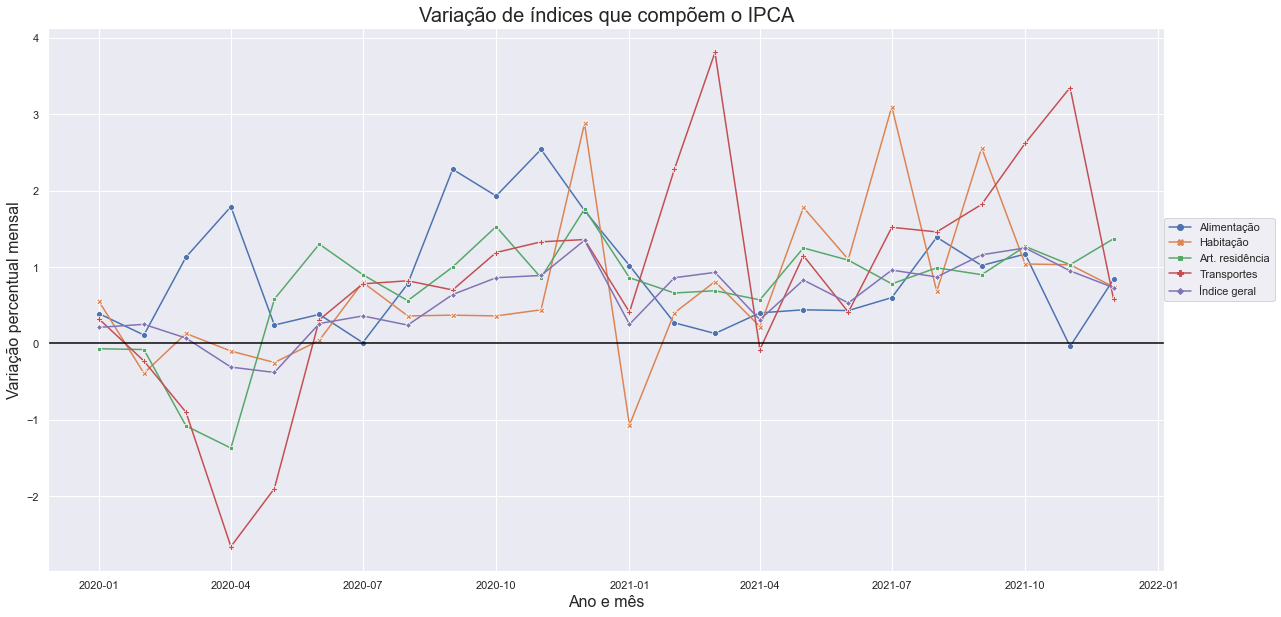

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
#Realizando o gráfico com essas variáveis
fig = sns.lineplot(data = df_ipca_indices_filtrado,
                   x='anomes',
                   y='variacao_mensal',
                   hue='cat_1',
                   style='cat_1',
                   markers=True,
                   dashes=False)
#Adicionando uma linha horizontal em 0 à critério de visualização
fig.axhline(y=0, color='black', linestyle='-')

#Título, eixos e legenda
fig.set_title('Variação de índices que compõem o IPCA', fontsize=20)
fig.set_xlabel('Ano e mês', fontsize=16)
fig.set_ylabel('Variação percentual mensal', fontsize=16)
plt.legend(bbox_to_anchor=(1, 0.65),  borderaxespad=0.)


In [17]:
#Pequeno script pra saber os principais bens e serviços que compõem a categoria
df_ipca[(df_ipca['cat_1'] == 'Alimentação') &
        (df_ipca['anomes'] == datetime.date(2021,12,1))][['categoria', 'peso_mensal']].sort_values(by='peso_mensal', ascending = False).head(15)

,categoria,peso_mensal
207,Alimentação e bebidas,20.6914
653,Alimentação no domicílio,14.9750
654,Alimentação fora do domicílio,5.7164
1861,Alimentação fora do domicílio,5.7164
10726,Refeição,3.5618
1851,Carnes,2.9444
1855,Leites e derivados,1.7232
10727,Lanche,1.6449
1858,Bebidas e infusões,1.5992
1856,Panificados,1.5384


# Análise e Conclusão
O gráfico inicia a série histórica em janeiro de 2020, e sabemos que o primeiro impacto da pandemia ocorreu em meados de março do mesmo ano. Sendo assim, é possível ver em abril/20 a maior queda, principalmente no custo do **Transporte**, já que muitas pessoas ficaram afastadas ou fazendo Trabalho Remoto no período. Após esse perído, enxergamos grandes picos de mudança no índice de preços do **Transporte**, motivado principalmente por alterações no custo do combustível e por picos de demanda por conta da flexibilização das medidas de restrição. Além disso, vale comentar que **Transportes** é o índice com maior peso (21,9%) no cálculo do IPCA.

Os valores de **Habitação** também não seguem uma trajetória linear regular, mas sim apresentam grandes picos e vales, normalmente ocasionados pelas alterações dos contratos de aluguel. É por isso que enxergamos um gande pico em dez/20 e o maior vale em jan/21. **Habitação** tem um peso de 16,1% na composição do índice geral.

A série de **Artigos Residenciais** apresenta informações muito interessantes. Ela tem uma correlação muito alta com o IPCA de cerca de 68%, porém representa apenas 3,8% da composição do índice, sendo assim a série que menos favorece o próprio índice. Como **Transporte** e **Habitação** tem um peso relativamente alto na composição do índice geral, é esperada uma alta correlação. **Artigos Residenciais** corrobora pouco com a composição do índice.

Por fim, **Alimentação** traz uma observação semelhante a de **Artigos Residenciais**, porém de outra forma: **Alimentação** tem um peso de quase 20% na composição do índice geral, porém apresenta uma correlação de 0,2, ou seja, basicamente o peso da própria série. Ao observarmos os valores da série de **Alimentação** encontramos realmente grandes variações, ocasionadas por épocas do ano, variações do dólar, quebras de safra, custo de transporte e até demanda internacional. Por isso, é de se esperar que seja o índice com a maior variação.